## INITIALIZATION

In [1]:
%matplotlib notebook
import numpy as np
import time
import tables as tb
import matplotlib.pyplot as plt

from tjmonopix.tjmonopix import TJMonoPix
from tjmonopix.online_monitor import noise_monitor, plots
from tjmonopix.analysis import analysis_functions

import tjmonopix.scans.injection_scan

chip = TJMonoPix(conf="../tjmonopix/tjmonopix_mio3.yaml", no_power_reset=False)
chip.init(fl="EN_HV")

chip['data_rx'].CONF_START_FREEZE = 64 #default 3
chip['data_rx'].CONF_STOP_FREEZE = 100 #default 40
chip['data_rx'].CONF_START_READ = 66 #default 6
chip['data_rx'].CONF_STOP_READ = 68 #default 7
chip['data_rx'].CONF_STOP = 105 #default 45


2022-02-03 12:29:09,763 [INFO ] (MainThread) GPAC: power reset
2022-02-03 12:29:11,529 [INFO ] (MainThread) Found adapter card: General Purpose Analog Card (GPAC) with ID 3
2022-02-03 12:29:11,767 [INFO ] (MainThread) Found board 0 running firmware version 0.0
2022-02-03 12:29:12,000 [INFO ] (MainThread) ibias = 45
2022-02-03 12:29:12,015 [INFO ] (MainThread) ibias = 503.125 nA
2022-02-03 12:29:12,569 [INFO ] (MainThread) {'VPC [V]': 1.2998506463536463, 'VDDA_DAC [mA]': 2.502471747485684, 'VDDP [V]': 1.8049802771084336, 'VDDP OC': False, 'VDDA [mA]': 50.151368865825674, 'VDDD [V]': 1.8015140363636364, 'VDDA_DAC OC': False, 'VDDD [mA]': 2.820288999038665e-08, 'VPCSWSF [V]': 0.5001542395802099, 'VDDP [mA]': 128.39714805315754, 'BiasSF [V]': 1.0622801785996314, 'VDDD OC': False, 'VPC [mA]': 0.26299884670954615, 'VPCSWSF [mA]': -0.10855385796052658, 'VDDA [V]': 1.8058565495495498, 'VDDA OC': False, 'VDDA_DAC [V]': 1.8035484515484517, 'BiasSF [mA]': 0.10059447096451782}


## POWER STATUS

In [2]:
#chip['BiasSF'].set_current(100, unit='uA') # SET THE SOURCE FOLLOWER READOUT CURRENT
chip.get_power_status()

{'BiasSF [V]': 1.062780289971045,
 'BiasSF [mA]': 0.10059447096451782,
 'VDDA OC': False,
 'VDDA [V]': 1.8058565495495498,
 'VDDA [mA]': 50.151368865825674,
 'VDDA_DAC OC': False,
 'VDDA_DAC [V]': 1.8035484515484517,
 'VDDA_DAC [mA]': 2.502471747485684,
 'VDDD OC': False,
 'VDDD [V]': 1.8015140363636364,
 'VDDD [mA]': 2.820288999038665e-08,
 'VDDP OC': False,
 'VDDP [V]': 1.8049802771084336,
 'VDDP [mA]': 128.39714805315754,
 'VPC [V]': 1.3003497122377623,
 'VPC [mA]': 0.1209994722628102,
 'VPCSWSF [V]': 0.5001542395802099,
 'VPCSWSF [mA]': 0.1810898620571381}

In [ ]:
# SELECT WHICH DOUBLE COLUMNS (PIXEL "FLAVOURS") TO ENABLE
chip['CONF_SR']['EN_PMOS_NOSF'].setall(False)
chip['CONF_SR']['EN_PMOS'].setall(False)
chip['CONF_SR']['EN_COMP'].setall(False)
chip['CONF_SR']['EN_HV'].setall(True)
chip['CONF_SR']['EN_OUT'].setall(False) #ENABLES OR DISABLES THE NORMAL OUTPUT PADS, ACTIVE LOW
chip['CONF_SR']['nEN_OUT'].setall(True) #ENABLES OR DISABLES THE COMPLEMENTARY OUTPUT PADS, ACTIVE LOW
chip['CONF_SR']['EN_HITOR_OUT'].setall(True) #ENABLES OR DISABLES THE NORMAL HITOR PADS, HITOR0-3 =  1-4 flavor, ACTIVE LOW
chip['CONF_SR']['nEN_HITOR_OUT'].setall(True) #ENABLES OR DISABLES THE COMPLEMENTARY HITOR PADS, ACTIVE LOW
chip.write_conf()

# SELECT WHICH PHYSICAL COLUMS TO INJECT
# INJ_IN_MON_L AND INJ_IN_MON_L SELECT THE LEFT AND RIGHT SPECIAL ANALOG MONITORING PIXELS
chip['CONF_SR']['COL_PULSE_SEL'].setall(False)

chip['CONF_SR']['INJ_IN_MON_L'] = 1 # ENABLE INJECTION FOR THE ANALOG MONITORING PIXELS LEFT SIDE
chip['CONF_SR']['INJ_IN_MON_R'] = 1 # ENABLE INJECTION FOR THE ANALOG MONITORING PIXELS RIGHT SIDE

# SELECT WHICH PHYSICAL ROWS TO INJECT
# THE SPEXIAL PIXELS OUTA_MON3 to OUTA_MON0 CORRESPONT TO ROWS 223 to 220 FOR INJECTION
chip['CONF_SR']['INJ_ROW'].setall(False)
chip['CONF_SR']['INJ_ROW'][223:220] = True # FOR THE ANALOG MONITORING TOP PIXEL

# SELECT PHYSICAL COLUMNS AND ROWS FOR INJECTION WITH FUNCTION
#chip.enable_injection(3,18,99)
chip.write_conf()


# SELECT PHYSICAL COLUMN(S) FOR HITOR OUTPUT
# nMASKH (SO SETTING MASKH TO FALSE) ENABLES HITOR FOR THE SPECIFIC ROW
chip['CONF_SR']['DIG_MON_SEL'].setall(False)
#chip.enable_column_hitor(1,18)

chip.write_conf()

## ANALOG FRONT END CONFIGURATION

In [3]:
vl_dac = 40
vh_dac = 80
vreset_dac = 35
icasn_dac = 0  # This sets the baseline voltage of the discriminator input
ireset_dac = 2
ithr_dac = 5  # Also this sets the baseline voltage of the discriminator input
idb_dac = 50  # This sets the threshold of the discriminator. It is changed later.
ibias_dac = 100

## SET THE INJECTION PULSE AMPLITUDE
## 128-bit DAC (7-bit binary equivalent)
## SET THE VOLTAGES IN ONE HOT ENCODING, ONLY ONE BIT ACTIVE AT A TIME.
## V = (127/1.8)*#BIT
# The default values are VL=44, VH=79, VH-VL=35
# VDAC LSB=14.17mV, Cinj=230aF, 1.43e-/mV, ~710e-  
CAPCAL=20.3439450687
vl = chip.set_vl_dacunits(vl_dac,1)
vh = chip.set_vh_dacunits(vh_dac,1)

chip.write_conf()

# SET VRESET_P, THIS IS THE BASELINE OF THE FRONT END INPUT, ONE HOT ENCODING
vreset = chip.set_vreset_dacunits(vreset_dac, 1) #1V

## 128-bit DAC (7-bit binary equivalent)
## SET THE CURRENTS USING THERMOMETER ENCODING, I = #BITS_ACTIVE*140nA*SCALING, SCALING IS DIFFERENT FOR EACH CURRENT
## SCALING: IBIAS=10, IDB=16, ITHR=0.125, ICASN=4, IRESET=0.03125
## ACTIVE BITS SHOULD BE SET STARTING FROM THE MIDDLE e.g. for 15 active bits, (128-15)/2=56,5 so 56zeros,15ones,57zeros
## Thus, Ix[71:57] = True

# SET ICASN, THIS CURRENT CONTROLS THE OUTPUT BASELINE, BE CAREFUL NOT TO SET IT TO HIGH
# ALWAYS MONITOR THE POWER AFTER SETTING ICASN. IF VDDD IS SEVERAL mA, REDUCE IT UNTIL IT RETURNS TO 0
# ICASN MAINLY CONTROLS THE THRESHOLD
icasn = chip.set_icasn_dacunits(icasn_dac,1) #4.375nA # approx 1.084V at -3V backbias, 600mV at 0V backbias

# SET IRESET, THIS CURRENT CONTROLS THE RESET RATE OF THE FRONT END INPUT (ALSO THE THRESHOLD)
ireset = chip.set_ireset_dacunits(ireset_dac,1,1) #270pA, HIGH LEAKAGE MODE, NORMAL SCALING, 0 = LOW LEAKAGE MODE, SCALING*0.01

# SET ITHR, THIS CURRENT CONTROLS THE RESET RATE OF THE OUTPUT (AND THE THRESHOLD)
ithr = chip.set_ithr_dacunits(ithr_dac,1) #680pA ## default=5

# SET ITHR, THIS CURRENT CONTROLS THE BIASING OF THE DISCRIMINATOR (AND THE THRESHOLD)
idb = chip.set_idb_dacunits(idb_dac,1) #500nA  

# SET IBIAS, THIS CURRENT IS THE DC CURRENT OF THE MAIN BRANCH OF THE FRONT END THAT PROVIDES AMPLIFICATION
# IT CONTROLS MAINLY THE RISE TIME
ibias = chip.set_ibias_dacunits(ibias_dac,1) #500nA default=50

############ ENABLE THE DAC CURRENT MONITORING ###########
# chip['CONF_SR']['SWCNTL_DACMONI'] = 0

########## SET THE BIAS CURRENTS OF THE TWO STAGE SOURCE FOLLOWER THAT BUFFERS THE ANALOG MONITORING VOLTAGES #########
# CONTROLS THE RESPONSE TIME AND THE LEVEL SHIFT OF THE BUFFER
# chip['CONF_SR']['SET_IBUFN_L'] = 0b1001
# chip['CONF_SR']['SET_IBUFP_L'] = 0b0101

chip.write_conf()


setted_param_dac = np.array([vl_dac, vh_dac, vreset_dac, icasn_dac, ireset_dac, ithr_dac, idb_dac, ibias_dac])
setted_param = np.array([vl, vh, vreset, icasn, ireset, ithr, idb, ibias])

2022-02-03 12:29:13,355 [INFO ] (MainThread) vl = 0.951929133858V
2022-02-03 12:29:13,371 [INFO ] (MainThread) vh = 1.51885826772V
2022-02-03 12:29:13,387 [INFO ] (MainThread) vreset = 1.05106299213V
2022-02-03 12:29:13,403 [INFO ] (MainThread) icasn = 0
2022-02-03 12:29:13,417 [INFO ] (MainThread) icasn = 4.375 nA
2022-02-03 12:29:13,434 [INFO ] (MainThread) ireset = 2 high leakage mode
2022-02-03 12:29:13,456 [INFO ] (MainThread) ireset = 0.1025390625nA, high leakage mode
2022-02-03 12:29:13,471 [INFO ] (MainThread) ithr = 5
2022-02-03 12:29:13,486 [INFO ] (MainThread) ithr = 0.8203125 nA
2022-02-03 12:29:13,503 [INFO ] (MainThread) idb = 50
2022-02-03 12:29:13,519 [INFO ] (MainThread) idb = 892.5 nA
2022-02-03 12:29:13,533 [INFO ] (MainThread) ibias = 100
2022-02-03 12:29:13,556 [INFO ] (MainThread) ibias = 1104.6875 nA


## ENABLE MASK AND GET OCCUPANCY

In [4]:
th = 2
step = 50
dt = 0.2

noisy_pixels, n_disabled_pixels, mask = chip.auto_mask(th=th, step=step, dt=dt)
print("========= Getting residual occupancy =============")
pix_tmp, cnt = chip.get_occupancy(dt);

Enable MASKH 50
Got 51708 hits, total noisy pixels: 32
Enable MASKH 100
Got 109743 hits, total noisy pixels: 93
Enable MASKH 150
Got 25185 hits, total noisy pixels: 143
Enable MASKH 200
Got 154516 hits, total noisy pixels: 210
Enable MASKH 223
Got 38564 hits, total noisy pixels: 236
Enable MASKV 50
Got 1261 hits, total noisy pixels: 238
Enable MASKV 100
Got 125 hits, total noisy pixels: 242
Enable MASKV 111
Got 9 hits, total noisy pixels: 242
Enable MASKD 50
Got 15 hits, total noisy pixels: 245
Enable MASKD 100
Got 8 hits, total noisy pixels: 247
Enable MASKD 150
Got 6 hits, total noisy pixels: 248
Enable MASKD 200
Got 112 hits, total noisy pixels: 251
Enable MASKD 250
Got 122 hits, total noisy pixels: 252
Enable MASKD 300
Got 81 hits, total noisy pixels: 255
Enable MASKD 350
Got 71 hits, total noisy pixels: 260
Enable MASKD 400
Got 93 hits, total noisy pixels: 262
Enable MASKD 447
Got 13 hits, total noisy pixels: 264
Checking again after masking
Got 37 hits, total noisy pixels: 266
No

# Configure injection and Select 1pixel 

2022-02-03 12:29:21,835 [INFO ] (MainThread) idb = 20
2022-02-03 12:29:21,851 [INFO ] (MainThread) idb = 367.5 nA
2022-02-03 12:29:21,868 [INFO ] (MainThread) vh = 1.80232283465V


Got 200 hits in 0.2 s


<IPython.core.display.Javascript object>


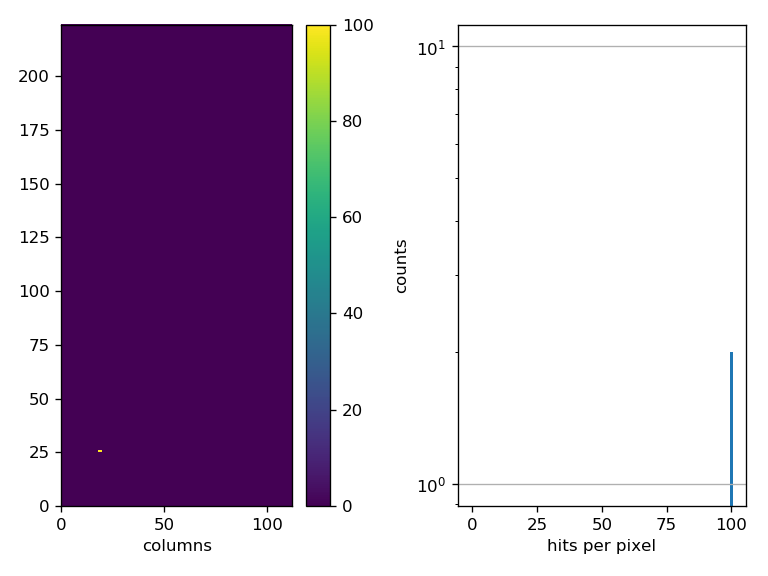

2022-02-03 12:29:24,361 [WARNI] (MainThread) Deprecated: Use get_FIFO_SIZE()


fifo size 2400
0 (19, 25) 100
1 (18, 25) 100


In [5]:
delay = 800 #in clock units (640 MHz)
width = 250
repeat = 100 #number of pulse injected
chip['inj'].set_delay(delay)
chip['inj'].set_width(width)
chip['inj'].set_repeat(repeat)
chip['inj'].set_phase(0)
chip['inj'].set_en(0)

idb = chip.set_idb_dacunits(20,1) #### threshold; SOPRA LA METTE CON 50 DAC
vh = chip.set_vh_dacunits(100,1) #### injection; SOPRA LA METTE CON 80 DAC
chip.write_conf()

chip.select_injection(col_to_inject, row_to_inject)

_, pixels, hits_per_pixel = plots.tj_plot(chip, wait_inj=True)
chip['data_rx'].set_en(False)

chip.set_monoread()
for _ in range(5):
    chip['fifo'].reset()
    time.sleep(0.002)
chip["inj"].start()
while not chip['inj'].is_ready:
    time.sleep(0.001)
time.sleep(0.2)

print "fifo size", chip['fifo'].get_fifo_size()
ix = chip.interpret_data(chip['fifo'].get_data())
uni, cnt = np.unique(ix[["col","row"]], return_counts = True)
arg = np.argsort(cnt)
for a_i, a in enumerate(arg[::-1]):
    print a_i, uni[a], cnt[a]

## run parameter space scan using injection_scan

In [8]:
idb = chip.set_idb_dacunits(20,1) 
vh = chip.set_vh_dacunits(80,1) # The functions below change vl w.r.t. vh
chip.write_conf()

scans = tjmonopix.scans.injection_scan.InjectionScan(dut=chip)

collist = [18]
rowlist = [2,10,25,100] #list(range(224))
injlist = np.arange(50, 0, -1)
thlist = [20]
output_filename = scans.start(
    collist = collist, rowlist = rowlist,
    injlist = injlist, thlist = thlist, phaselist = None,
    with_mon = False, n_mask_col = 112, debug = 4)

scans.analyze(output_filename)

2022-02-03 12:34:12,674 [INFO ] (MainThread) vh = 1.51885826772V
2022-02-03 12:34:12,690 [INFO ] (MainThread) idb = 20
2022-02-03 12:34:12,704 [INFO ] (MainThread) idb = 367.5 nA
2022-02-03 12:34:12,720 [INFO ] (MainThread) Initializing InjectionScan
2022-02-03 12:34:13,306 [INFO ] (MainThread) Power status: {'VPC [V]': 1.2998506463536463, 'VDDA_DAC [mA]': 2.502471747485684, 'VDDP [V]': 1.8049802771084336, 'VDDP OC': False, 'VDDA [mA]': 78.51981992834118, 'VDDD [V]': 1.8015140363636364, 'VDDA_DAC OC': False, 'VDDD [mA]': 2.820288999038665e-08, 'VPCSWSF [V]': 0.5001542395802099, 'VDDP [mA]': 128.39714805315754, 'BiasSF [V]': 1.063780512713872, 'VDDD OC': False, 'VPC [mA]': -0.1234994506401965, 'VPCSWSF [mA]': 0.06953450875154357, 'VDDA [V]': 1.8048574894894895, 'VDDA OC': False, 'VDDA_DAC [V]': 1.8045472377622378, 'BiasSF [mA]': 0.10059447096451782}
2022-02-03 12:34:13,391 [INFO ] (MainThread) Temperature (C): 29.953067
2022-02-03 12:34:13,444 [INFO ] (MainThread) Temperature (C): 30.09

0 69077 100.000% 0.000s 23026hits 0errs
data (inj_n 100,inj_loop 200): INJ=20000 MONO=3026 MON=0
0 23026 100.000% 0.263s 3026hits 0errs


'C:\\Users\\belle2\\tjmonopix-daq\\examples\\output_data\\20220203_123412_injection_ev.h5'